# WORK IN PROGRESS 
this section is dedicated to mamba models, this is going to be a naive and slow implementation in pytorch, optimized for understanding of the underlying concepts. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [2]:
with open("datasets/tinyShakespeare.txt", "r") as f:
    load = f.read()
print(load[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [3]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]

vocab_size = len(texttoint)
sequence_length = 20

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[2000:, :-1]
labels = sequences[2000:, -1]
val_inputs = sequences[:2000, :-1]
val_labels = sequences[:2000, -1]

In [4]:
class Mamba(nn.Module):
    def __init__(self, emb_size, hidden_size):
        super(Mamba, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_size)

        self.D = nn.Linear(emb_size, emb_size)
        self.B = nn.Linear(1, hidden_size)
        self.C = nn.Linear(hidden_size, 1)
        self.A = nn.Linear(hidden_size, hidden_size)

    def forward(self, x, h):
        x = self.emb(x)
        
        h1 = self.B(x.view(-1, 128, 1)) + self.A(h)
        #print(h1.mean().item(), h1.std().item())
        out = self.D(x)[:, 0] + self.C(h1)[..., 0]
        return out, h1


In [5]:
import torch
import torch.nn as nn
from tqdm import tqdm
from collections import deque

# Define hyperparameters
embedding_size = 128
hidden_size = 256
num_layers = 2
num_epochs = 10
learning_rate = 0.0001
batch_size = 1
trailing_loss_size = 2000  # Size of the trailing loss queue

# Initialize the model, loss function, and optimizer
model = Mamba(embedding_size, hidden_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize trailing loss queue
loss_queue = deque(maxlen=trailing_loss_size)

# Initialize list to store loss values
lossi = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    with tqdm(range(0, len(inputs)-batch_size, batch_size)) as p:
        for i in p:
            input_batch = inputs[i:i+batch_size].to(device)
            label_batch = labels[i:i+batch_size].to(device)

            # Initialize hidden state
            h = torch.zeros(batch_size, embedding_size, hidden_size).to(device)

            # Forward pass
            total_batch_loss = 0
            for t in range(input_batch.size(1)):
                char_input = input_batch[:, t].unsqueeze(1)
                outputs, h = model(char_input, h)
                loss = criterion(outputs.squeeze(1), label_batch)
                total_batch_loss += loss
                loss_queue.append(loss.item())
            
            # Calculate trailing loss
            avg_trailing_loss = sum(loss_queue) / len(loss_queue)
            p.set_description(f"Trailing Loss: {avg_trailing_loss:.4f}")

            # Backward pass and optimization
            optimizer.zero_grad()
            total_batch_loss.backward()
            optimizer.step()

            total_loss += total_batch_loss.item()
            lossi.append(total_batch_loss.item())

    avg_loss = total_loss / (len(inputs) // batch_size)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    
# Save the model
torch.save(model.state_dict(), 'mamba_model.pth')

Trailing Loss: 3.4765:   1%|          | 8522/1113372 [03:32<7:39:04, 40.11it/s]


KeyboardInterrupt: 

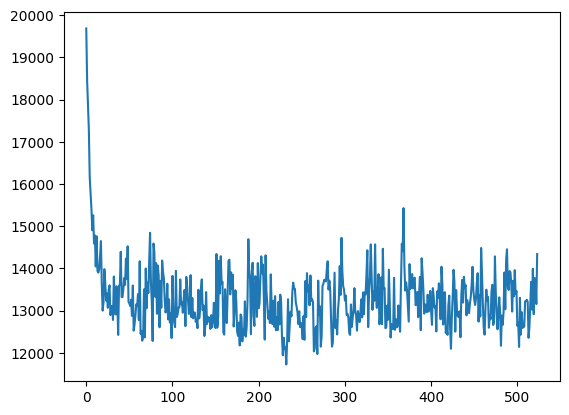

In [9]:
losst = [sum(lossi[i:i+200]) for i in range(0, len(lossi)-200, 200)]
plt.plot(losst)